In [ ]:
import torch 
import torch.nn as nn
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torchvision.transforms as transforms

Загрузим датасет:

In [ ]:
train_dataset = torchvision.datasets.MNIST('.', download=True, transform = transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST('.', download=True, train=False, transform = transforms.ToTensor())

train_x, train_y = train_dataset.train_data, train_dataset.train_labels
test_x, test_y = test_dataset.test_data, test_dataset.test_labels

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
# Создаем загрузчики для датасетов (DataLoader)

batch_size_train = 64
batch_size_test = 1000

#Загрузчик для тренировочного сета
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size_train, shuffle=True)

#Загрузчик для тестового сета
test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size_test, shuffle=True)

In [ ]:
print('Размер тренировочной выборки:', train_x.shape[0])
print('Размер тестовой выборки:', test_x.shape[0])
print('Размер одного объекта:', test_x.shape[1:])

Размер тренировочной выборки: 60000
Размер тестовой выборки: 10000
Размер одного объекта: torch.Size([28, 28])


In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, n_clasess: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_clasess),
            nn.Softmax(dim=1)
        )
    
    def forward(self, input_batch: torch.Tensor):
        output_batch = self.model(input_batch)
        return output_batch

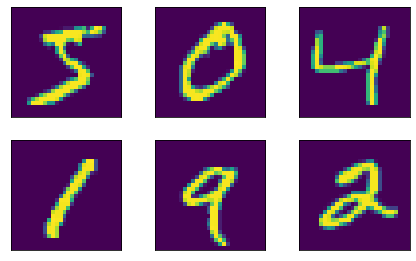

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_x[i])
  plt.xticks([])
  plt.yticks([])

Теперь нужно определить нужные компоненты для тренировки:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

В нашем наборе данных размер изображения 28 * 28. Таким образом, наш входной размер равен 784. Кроме того, в нем присутствует 10 цифр, и, следовательно, у нас может быть 10 различных выходных данных. Таким образом, мы устанавливаем num_classes равным 10.

In [ ]:
model = ImageClassifier(input_dim=test_x.shape[1]*test_x.shape[1], 
    hidden_dim=128, n_clasess = 10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
from torchsummary import summary
print(model)
summary(model, (32, 784))

ImageClassifier(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 128]         100,480
              ReLU-2              [-1, 32, 128]               0
            Linear-3               [-1, 32, 10]           1,290
           Softmax-4               [-1, 32, 10]               0
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.07
Params size (MB): 0.39
Estimated Total Size (MB): 0.55
----------------------------------------------------------------


А теперь train loop:

In [ ]:
batch_size = 64  # Размер батча (столько объектов обрабатываются нейросетью за один forward pass)
losses = []
eval_losses = []
n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    current_epoch_train_losses = []
    for i in tqdm(range(0, train_x.shape[0], batch_size), 
                  desc='Training epoch {} from {}'.format(epoch, n_epochs)):
        x_batch = train_x[i: i + batch_size].to(device) 
        y_batch = train_y[i: i + batch_size].to(device)

        x_batch = torch.flatten(x_batch.float(), start_dim=1)

        optimizer.zero_grad() # Обнуление градиента 

        model_output = model(x_batch)# forward pass
        loss = criterion(model_output, y_batch)
        # backward
        # шаг градиентного спуска
        
        loss.backward()
        optimizer.step()
        current_epoch_train_losses.append(loss.item())
    losses.append(np.array(current_epoch_train_losses).mean())

    # Evaluation step
    model.eval()
    current_epoch_eval_losses = []
    current_epoch_eval_acc = []
    for i in range(0, test_x.shape[0], batch_size):
        x_batch = test_x[i: i + batch_size].to(device)
        y_batch = test_y[i: i + batch_size].to(device)

        x_batch = torch.flatten(x_batch.float(), start_dim=1)

        with torch.no_grad():
            # Так как на валидации мы не оптимизируем модель, 
            # то нам не нужно считать градиенты. 
            # Поэтому мы воспользовалиь torch.no_grad(). 

            model_output = model(x_batch)# forward pass
            loss =  criterion(model_output, y_batch)#ошибка по батчу
        current_epoch_eval_losses.append(loss.item())
    eval_losses.append(np.array(current_epoch_eval_losses).mean())


Training epoch 0 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 10 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 11 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 12 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 13 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 14 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 15 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 16 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 17 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 18 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 19 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Нарисуйте графики для train и val лоссов - какие выводы/наблюдения вы можете сделать по ним?

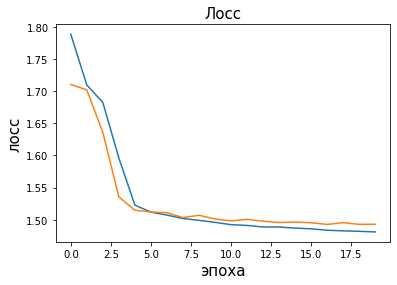

In [ ]:
    plt.title('Лосс', fontsize=15)
    plt.plot(losses, label='train')
    plt.plot(eval_losses, label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15);

Графики лоссов почти идентичны, до 5 эпох лосс сильно уменьшается, после идёт медленное сползание лосса вниз

In [ ]:
from torch.autograd import Variable
correct = 0
total = 0
for images, labels in test_loader:
  images = Variable(images.view( - 1 , 28 * 28 ))
  outputs = model(images)
  _, predicted = torch. max (outputs.data, 1 )
  total += labels.size( 0 )
  correct += (predicted == labels). sum ()
print ( 'Точность: % d %%' % (
100 * correct / total))

Точность:  90 %


Дополнительное задание:

Поэкспериментируйте с разными архитектурами (добавить батч нормализацию и дропаут) и гиперпарамтерами. Как изменилось качество модели? 

- При hidden_dim=1024, input_dim_2 = 256, input_dim_3 = 64, Total params: 1,083,338 точность: 9%
- При hidden_dim=64 Total params: 50,890 точность: 69%
- При hidden_dim=16 Total params: 12,730 точность: 66%
- При hidden_dim=32 Total params: 25,450 точность: 74%
- При hidden_dim=32 и Batchnorm1d Total params: 25,514 точность: 10%
- При hidden_dim=32 и Batchnorm1d, и Dropout(0.2) Total params: 25,514 точность: 8%
- При hidden_dim=32 и Dropout(0.2) Total params: 25,450 точность: 80%
- При hidden_dim=32 и Dropout(0.4) Total params: 25,450 точность: 10%
- При hidden_dim=32 и Dropout(0.1) Total params: 25,450 точность: 64%
- При hidden_dim=32 и Dropout(0.25) Total params: 25,450 точность: 83%
- При hidden_dim=32 и Dropout(0.25), и batch_size =32  Total params: 25,450 точность: 83%
- При hidden_dim=256, hidden_dim_2 = 64 и Dropout(0.2)(x2), и batch_size =64  Total params: 218,058 точность: 77%
- При hidden_dim=128, Adam.lr=0.0001, n_epochs = 20, Total params: 101,770 точность: 90%